In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import re
from pydub import AudioSegment
import torch
import torch.nn as nn
from google.colab import drive
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [64]:
# Define the EMOTIONS dictionary
EMOTIONS = {0: 'low', 1: 'neutral', 2: 'high'}
parent_folder = '/content/drive/MyDrive/Colab Notebooks/recordings'
SAMPLE_RATE = 16000
drive.mount('/content/drive')


# Initialize an empty list to store the dataset rows
data = []

# Iterate over each folder (0-6)
for folder_name in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder_name)

    # Iterate over each audio file in the folder
    for audio_file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, audio_file)

        # Extract information from the filename
        speaker_id, speaker_gender, speaker_age, spoken_word, spoken_emotion, record_id = audio_file.split('-')
        record_id = re.sub(r'\D', '', record_id)  # Remove non-numeric characters
        audio = AudioSegment.from_file(file_path)

        # Append the extracted information to the data list
        data.append({
            "Name": audio_file,
            "Emotion": int(spoken_emotion),
            "Emotion_Label": EMOTIONS[int(spoken_emotion)],
            "Gender": speaker_gender,
            "Speaker_ID": int(speaker_id),
            "Speaker_Age": int(speaker_age),
            "Spoken_Word": int(spoken_word),
            "Record_ID": int(record_id),
            "Path": file_path
        })




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
Data = pd.DataFrame(data)
Data.head()

,Name,Emotion,Emotion_Label,Gender,Speaker_ID,Speaker_Age,Spoken_Word,Record_ID,Path
0,10-f-20-0-1-0.wav,1,neutral,f,10,20,0,0,/content/drive/MyDrive/Colab Notebooks/recordi...
1,0-m-21-0-2-106.wav,2,high,m,0,21,0,106,/content/drive/MyDrive/Colab Notebooks/recordi...
2,0-m-21-0-1-105.wav,1,neutral,m,0,21,0,105,/content/drive/MyDrive/Colab Notebooks/recordi...
3,1-m-20-0-1-107.wav,1,neutral,m,1,20,0,107,/content/drive/MyDrive/Colab Notebooks/recordi...
4,102-f-40-0-2-5.wav,2,high,f,102,40,0,5,/content/drive/MyDrive/Colab Notebooks/recordi...


Text(0, 0.5, 'Number of examples')

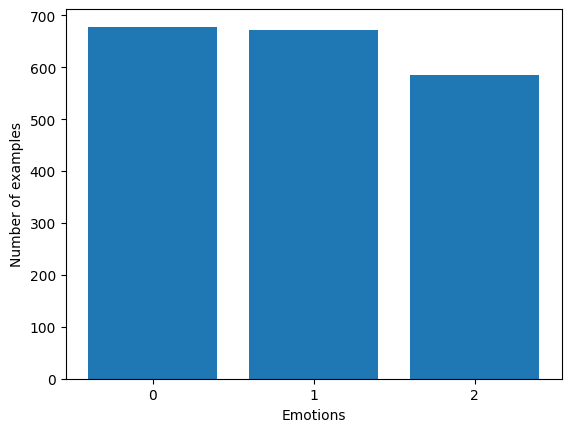

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(3), height=Data['Emotion'].value_counts())
ax.set_xticks(ticks=range(3))
ax.set_xticklabels([EMOTIONS[i] for i in EMOTIONS ],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

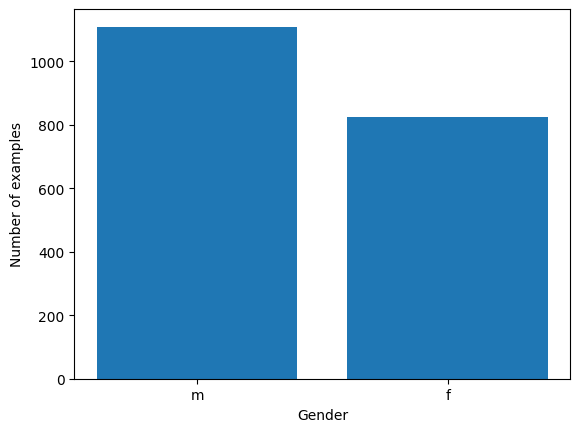

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = Data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

In [108]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

MEL spectrogram shape:  (128, 188)


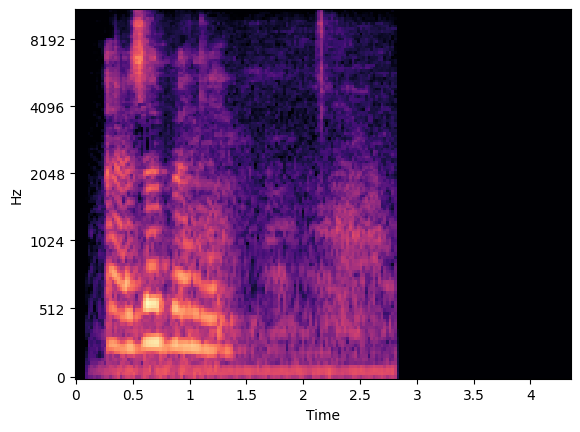

In [109]:
audio, sample_rate = librosa.load(Data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [110]:
print("number of files is {}".format(len(data)))

number of files is 1935


In [111]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(Data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
    mel_spectrograms.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,len(Data)),end='')

 Processed 1934/1935 files

In [112]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K
    # Generate noisy signal
    return signal + K.T * noise

In [113]:
for i,signal in enumerate(signals):
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        mel_spectrogram = getMELspectrogram(augmented_signals[j,:], sample_rate=SAMPLE_RATE)
        mel_spectrograms.append(mel_spectrogram)
        Data = pd.concat([Data, Data.iloc[i:i+1]], ignore_index=True)
    print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 1934/1935 files

In [114]:
class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+64,num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1)

        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm

In [115]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [116]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [117]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [118]:
X = np.stack(mel_spectrograms,axis=0)
X = np.expand_dims(X,1)
print('Shape of data: ',X.shape)

del mel_spectrograms
del signals

Shape of data:  (5805, 1, 128, 188)


In [119]:
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(Data.loc[Data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:,:,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:,:,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:,:,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(4643, 1, 128, 188), Y_train:(4643,)
X_val:(580, 1, 128, 188), Y_val:(580,)
X_test:(582, 1, 128, 188), Y_test:(582,)
Number of unique indexes is 5805, out of 5805


In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ', sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.SGD(model.parameters(), lr=0.075, weight_decay=1e-3, momentum=0.8)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_step = make_train_step(model, loss_fnc, optimizer=optimizer)
validate = make_validate_fnc(model, loss_fnc)
losses = []
val_losses = []

# Training loop with learning rate scheduler
for epoch in range(EPOCHS):
    # Shuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end - batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X, device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)
        loss, acc = train_step(X_tensor, Y_tensor)
        epoch_acc += acc * actual_batch_size / DATASET_SIZE
        epoch_loss += loss * actual_batch_size / DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}", end='')

    # Adjust learning rate based on validation loss
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor, Y_val_tensor)
    scheduler.step(val_loss)

    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")


Selected device is cuda
Number of trainable params:  260452


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


 Epoch 0: iteration 144/145
Epoch 0 --> loss:1.2608, acc:41.09%, val_loss:0.9663, val_acc:48.97%
 Epoch 1: iteration 144/145
Epoch 1 --> loss:0.9195, acc:53.24%, val_loss:0.8120, val_acc:61.90%
 Epoch 2: iteration 144/145
Epoch 2 --> loss:0.8178, acc:60.72%, val_loss:0.8173, val_acc:63.97%
 Epoch 3: iteration 144/145
Epoch 3 --> loss:0.7426, acc:65.65%, val_loss:0.7237, val_acc:63.97%
 Epoch 4: iteration 144/145
Epoch 4 --> loss:0.6973, acc:67.91%, val_loss:0.6398, val_acc:74.66%
 Epoch 5: iteration 144/145
Epoch 5 --> loss:0.6270, acc:71.87%, val_loss:0.5605, val_acc:77.59%
 Epoch 6: iteration 144/145
Epoch 6 --> loss:0.5987, acc:73.06%, val_loss:0.5454, val_acc:78.10%
 Epoch 7: iteration 144/145
Epoch 7 --> loss:0.5604, acc:75.62%, val_loss:0.5222, val_acc:76.55%
 Epoch 8: iteration 144/145
Epoch 8 --> loss:0.5442, acc:76.61%, val_loss:0.6290, val_acc:70.17%
 Epoch 9: iteration 144/145
Epoch 9 --> loss:0.5100, acc:78.18%, val_loss:0.5995, val_acc:75.52%
 Epoch 10: iteration 144/145
E

In [122]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.112
Test accuracy is 96.56%


In [59]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'Parallel_Cnn_Attention_LSTM3.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'Parallel_Cnn_Attention_LSTM3.pt')))

Model is saved to /content/models/Parallel_Cnn_Attention_LSTM3.pt


In [123]:
if isinstance(predictions, torch.Tensor):
    predictions = predictions.cpu().numpy()
if isinstance(Y_test_tensor, torch.Tensor):
    Y_test = Y_test_tensor.cpu().numpy()
else:
    Y_test = Y_test_tensor

# Define the target names for the classification report
EMOTIONS = [0, 1, 2]  # This should be a list of integers representing your classes
EMOTION_NAMES = {0: 'low', 1: 'neutral', 2: 'high'}
target_names = [EMOTION_NAMES[emotion] for emotion in EMOTIONS]

# Generate the classification report
report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

         low       0.98      0.97      0.97       176
     neutral       0.94      0.97      0.95       202
        high       0.98      0.97      0.97       204

    accuracy                           0.97       582
   macro avg       0.97      0.97      0.97       582
weighted avg       0.97      0.97      0.97       582



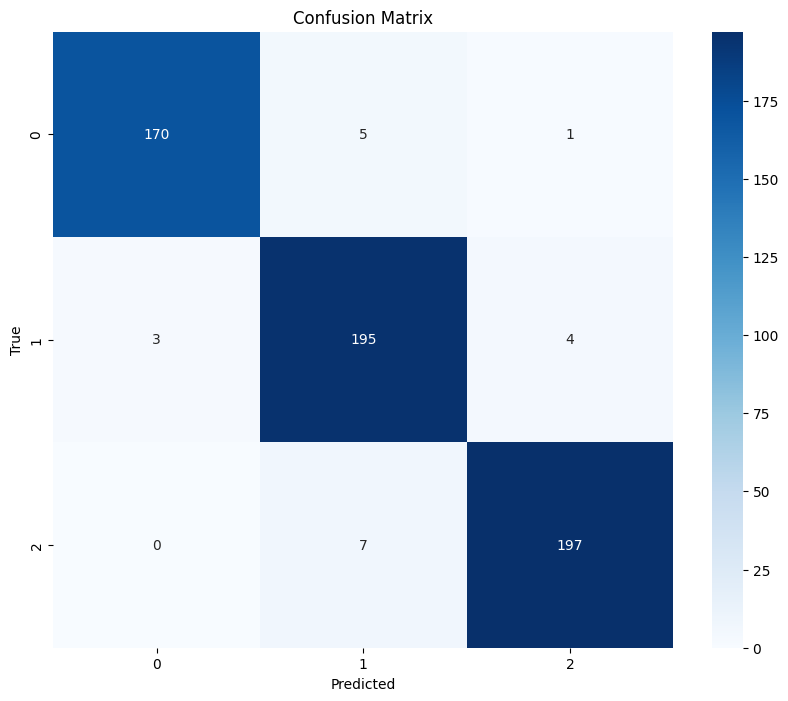

In [124]:
# Generate the confusion matrix
import seaborn as sns

conf_matrix = confusion_matrix(Y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()